# Determining buyer's age by image
Objective MAE < 8. 

## Dataset analysis

In [5]:
import pandas as pd 
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [5]:
print(labels)

       file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]


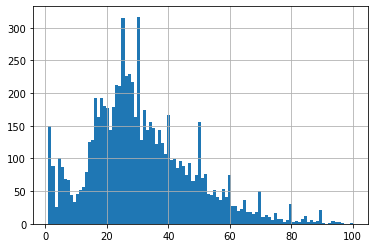

In [9]:
labels['real_age'].hist(bins = 100)

### Distribution summary


100 bins were takes to stretch the plot.
Visually can be found:
1. Children up to 4 years old. Keeping in mind our project, it is unlikely that these children are going to pay at the checkout. Also peak at 0 can be seen, so apparently we got pictures when parents keep babys at hands. 
2. It is right skewed distribution, so for people older than 70 we got much less images it will affect quality of model. IF we had equal number of images for each age (uniform distribution) it would be better.

In [11]:
features, target = next(train_gen_flow)

In [13]:
print(target)

[50 41 46 85 14 40 14 53  4 32 14 23 37 62 21 58 43 32 25 94 30 16 23 18
 41 24 26 14 36 28 78 13]


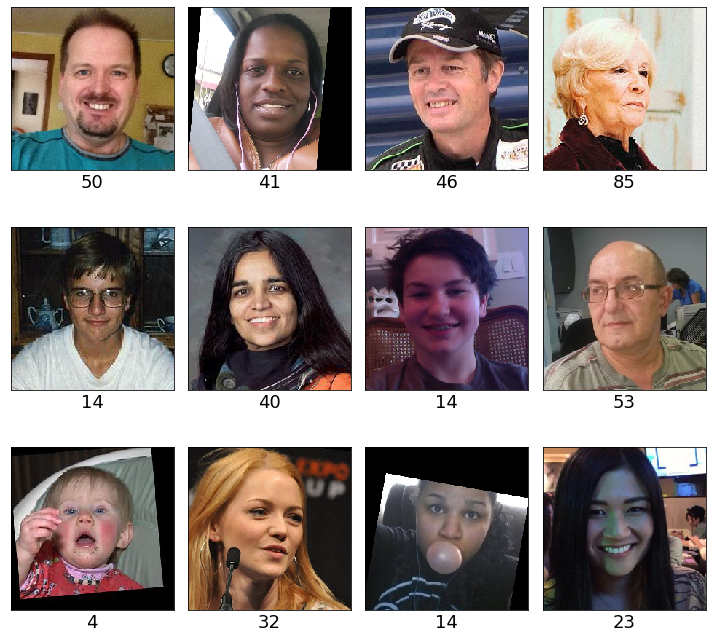

In [20]:
# have a look at 12 images with target value 
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(target[i], fontsize = 18)
    plt.tight_layout()

### Visual inspection

1. Dataset consist of mixed photos, some taken at home or at the office but not near cashierdesk. 
2. We have different head positions
3. Some images are augmented and have different sizes


## Training

```python


import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    '''
    Preparation of train dataset
    
    1. normalizing data in terms colors representation to train efficiently 
    2. do augmentation, i.e fliping the data
    3. defining batch size
    4. resizing images to 224 by 224, because in training data set we are given images with different sizes
       so for model it will be easier to infer from images that have standart size
    '''
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    '''
    Preparation of test dataset
    '''
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    '''
    Initializing model and defining parameters
    
    '''
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```
Train for 356 steps, validate for 119 steps
Epoch 1/20
2021-04-12 15:36:19.202284: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-12 15:36:23.273096: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 157s - loss: 203.7608 - mae: 10.7903 - val_loss: 290.2822 - val_mae: 12.8054
Epoch 2/20
356/356 - 43s - loss: 129.4077 - mae: 8.7309 - val_loss: 264.6709 - val_mae: 12.3007
Epoch 3/20
356/356 - 43s - loss: 109.2555 - mae: 8.0073 - val_loss: 135.4612 - val_mae: 8.7143
Epoch 4/20
356/356 - 43s - loss: 91.0060 - mae: 7.3103 - val_loss: 212.9770 - val_mae: 12.1559
Epoch 5/20
356/356 - 43s - loss: 74.4161 - mae: 6.5907 - val_loss: 164.5095 - val_mae: 9.6281
Epoch 6/20
356/356 - 43s - loss: 61.3248 - mae: 6.0184 - val_loss: 138.0998 - val_mae: 8.6687
Epoch 7/20
356/356 - 43s - loss: 57.0463 - mae: 5.7902 - val_loss: 109.9793 - val_mae: 8.2547
Epoch 8/20
356/356 - 43s - loss: 52.1093 - mae: 5.5286 - val_loss: 207.3802 - val_mae: 11.0505
Epoch 9/20
356/356 - 43s - loss: 44.0558 - mae: 5.0882 - val_loss: 84.2531 - val_mae: 6.9851
Epoch 10/20
356/356 - 43s - loss: 34.1814 - mae: 4.5161 - val_loss: 127.1175 - val_mae: 8.8210
Epoch 11/20
356/356 - 43s - loss: 30.9173 - mae: 4.3144 - val_loss: 88.2417 - val_mae: 7.2708
Epoch 12/20
356/356 - 44s - loss: 27.4785 - mae: 4.0498 - val_loss: 92.5949 - val_mae: 7.3619
Epoch 13/20
356/356 - 43s - loss: 24.2290 - mae: 3.7791 - val_loss: 91.0009 - val_mae: 7.1956
Epoch 14/20
356/356 - 43s - loss: 21.4071 - mae: 3.5819 - val_loss: 122.1515 - val_mae: 8.6770
Epoch 15/20
356/356 - 43s - loss: 20.6937 - mae: 3.5112 - val_loss: 96.6235 - val_mae: 7.4865
Epoch 16/20
356/356 - 44s - loss: 21.6983 - mae: 3.5739 - val_loss: 94.0746 - val_mae: 7.4832
Epoch 17/20
356/356 - 43s - loss: 26.4093 - mae: 3.8539 - val_loss: 111.9114 - val_mae: 8.0949
Epoch 18/20
356/356 - 44s - loss: 28.4121 - mae: 4.0855 - val_loss: 75.4118 - val_mae: 6.4982
Epoch 19/20
356/356 - 44s - loss: 19.5541 - mae: 3.3923 - val_loss: 74.3107 - val_mae: 6.4924
Epoch 20/20
356/356 - 43s - loss: 15.4099 - mae: 3.0062 - val_loss: 75.7543 - val_mae: 6.5951
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 75.7543 - mae: 6.5951
Test MAE: 6.5951


```

# Summary

1. Output numbers commented: 

    We were given 7591 images.
    75%  of them or 5693 images we use to train model.
    batch size = 16 images. 
    So to go throung one epoch we take 5693/16 = 355,82 (round up - 356) steps.

    Test data 25% - 1897,75 images.
    1897,75/16 = 118,6 (round up - 119) steps per epoch.
    
2. We took 20 epochs to train. MAE (training) = 3.0062. MAE (testing) = 6.5951 so we reash oir objective MAE < 8.

3. Risks:

    a) we got pictures with kids. These pictures doesn't give use much values for this projects cos kids are not going to pay at cash register in the store
    
    b) images of people of diffrent age are not normally distributed, particularly we have much less images of older people. So our model will not be we as afficient to detect  older people as younger people. 
    
